In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None):
    plt.grid(True)
    plt.plot(x, y, "o")
    k, b = mnk_non_zero(x, y)
    if(xmin == None):
        xmin = x.min().value
    if(xmax == None):
        xmax = x.max().value
    xl = np.array([xmin, xmax])
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
    else:
        y_value = y
        y_error = [0]*len(y_error)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x.min().value
    if(xmax == None):
        xmax = x.max().value
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



In [152]:
v_0 = DData(-0.013, 0.002, E = -3)
v_0.E = -6
T_0 = DData(15.85, 0.04)

In [153]:
data_raw = pd.read_csv("data.csv")
data_raw
data = data_raw
data["P"] = data["P"].apply(lambda x: DData(x, 0.1))
data["V"] = data["V"].apply(lambda x: DData(x, 2, E = -6))
data["T0"] = data["T0"].apply(lambda x: DData(x, 0.02))
T_v = []
for i in data.index:
    t0 = data["T0"][i]
    v = data["V"][i]
    k = DData(1, 0.5, E = -6)
    if(t0 < 20):
        k.value = 39.8
    elif(t0 < 30):
        k.value = 40.7
    elif(t0 < 40):
        k.value = 41.5
    elif(t0 < 50):
        k.value = 42.4
    elif(t0 < 60):
        k.value = 43.2
    elif(t0 < 70):
        k.value = 44.1
    T_v.append(v/k)
data["T"] = T_v
data

,P,V,T0,T
0,$4.00 \pm 0.10$,$127.0 \pm 2.0$,$16.130 \pm 0.020$,$3.191 \pm 0.064$
1,$3.60 \pm 0.10$,$112.0 \pm 2.0$,$16.150 \pm 0.020$,$2.814 \pm 0.061$
2,$2.90 \pm 0.10$,$85.0 \pm 2.0$,$16.250 \pm 0.020$,$2.136 \pm 0.057$
3,$2.60 \pm 0.10$,$74.0 \pm 2.0$,$16.310 \pm 0.020$,$1.859 \pm 0.055$
4,$1.90 \pm 0.10$,$50.0 \pm 2.0$,$16.380 \pm 0.020$,$1.256 \pm 0.053$
5,$1.60 \pm 0.10$,$39.0 \pm 2.0$,$16.430 \pm 0.020$,$0.980 \pm 0.052$
6,$4.00 \pm 0.10$,$129.0 \pm 2.0$,$25.050 \pm 0.020$,$3.170 \pm 0.063$
7,$3.50 \pm 0.10$,$106.0 \pm 2.0$,$25.080 \pm 0.020$,$2.604 \pm 0.059$
8,$3.10 \pm 0.10$,$93.0 \pm 2.0$,$25.080 \pm 0.020$,$2.285 \pm 0.057$
9,$2.60 \pm 0.10$,$75.0 \pm 2.0$,$25.090 \pm 0.020$,$1.843 \pm 0.054$


In [154]:
data_T_prik = pd.DataFrame()
T_prik = []
df_prik = []
for i in [10, 20, 30, 40, 50, 60]:
    df_c = data[data["T0"] > i][data["T0"] < i+10] 
    if(len(df_c)<2):
        continue
    T_prik.append(SerDData(df_c["T0"]).mean)
    df_prik.append(df_c)

data_T_prik["T"] = T_prik
data_T_prik["df"] = df_prik
data_T_prik

C:\Users\Alexey\AppData\Local\Temp\ipykernel_22400\4184607724.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_c = data[data["T0"] > i][data["T0"] < i+10]
C:\Users\Alexey\AppData\Local\Temp\ipykernel_22400\4184607724.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_c = data[data["T0"] > i][data["T0"] < i+10]
C:\Users\Alexey\AppData\Local\Temp\ipykernel_22400\4184607724.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_c = data[data["T0"] > i][data["T0"] < i+10]
C:\Users\Alexey\AppData\Local\Temp\ipykernel_22400\4184607724.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_c = data[data["T0"] > i][data["T0"] < i+10]
C:\Users\Alexey\AppData\Local\Temp\ipykernel_22400\4184607724.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_c = data[data["T0"] > i][data["T0"] < i+10]


,T,df
0,$16.275 \pm 0.028$,P V ...
1,$25.080 \pm 0.020$,P V ...
2,$35.028 \pm 0.020$,P V ...
3,$45.028 \pm 0.020$,P V ...
4,$55.000 \pm 0.020$,P V ...
5,$61.862 \pm 0.020$,P V ...


[1.36 4.24]
k, b = $0.920 \pm 0.011$ $-0.506 \pm 0.032$
[1.47 4.23]
k, b = $0.865 \pm 0.028$ $-0.366 \pm 0.082$
[1.02 4.38]
k, b = $0.715 \pm 0.013$ $0.051 \pm 0.039$
[2.13 4.17]
k, b = $0.732 \pm 0.017$ $-0.094 \pm 0.053$
[2.32 4.48]
k, b = $0.6676 \pm 0.0079$ $-0.041 \pm 0.027$
[2.3 4.7]
k, b = $0.595 \pm 0.014$ $0.099 \pm 0.051$


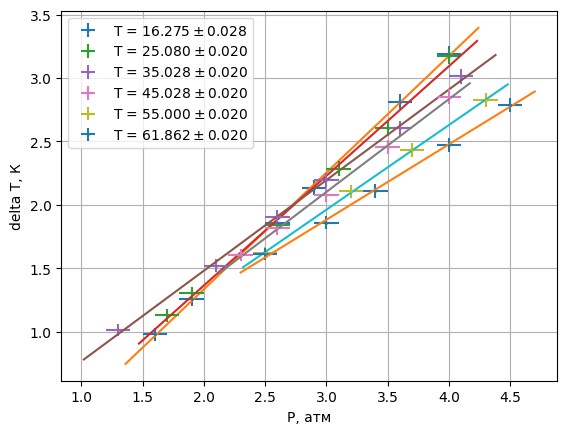

In [155]:
mu = []
for i in range(len(data_T_prik)):
    df = data_T_prik["df"][i]
    T0 = data_T_prik["T"][i]
    df.index = range(len(df))
    #plt.figure()
    plt.xlabel("P, атм")
    plt.ylabel("delta T, К")
    k, _ = linearcalc_error(df["P"], df["T"], label = f"T = {T0}")
    plt.legend()
    mu.append(k)
data_T_prik["mu"] = mu
plt.savefig("TP", dpi=300)
data_T_prik["T"] = data_T_prik["T"] + 273.15


In [156]:
data_T_prik

,T,df,mu
0,$289.425 \pm 0.028$,P V ...,$0.920 \pm 0.011$
1,$298.230 \pm 0.020$,P V ...,$0.865 \pm 0.028$
2,$308.178 \pm 0.020$,P V ...,$0.715 \pm 0.013$
3,$318.178 \pm 0.020$,P V ...,$0.732 \pm 0.017$
4,$328.150 \pm 0.020$,P V ...,$0.6676 \pm 0.0079$
5,$335.012 \pm 0.020$,P V ...,$0.595 \pm 0.014$


In [157]:
data_output = pd.DataFrame()
data_output["$T_0$, °C"] = data_raw["T0"]
data_output["P, атм"] = data_raw["P"]
data_output["V, мкВ"] = data_raw["V"]
data_output["$\Delta T$, °C"] = data_raw["T"]
data_output

,"$T_0$, °C","P, атм","V, мкВ","$\Delta T$, °C"
0,$16.130 \pm 0.020$,$4.00 \pm 0.10$,$127.0 \pm 2.0$,$3.191 \pm 0.064$
1,$16.150 \pm 0.020$,$3.60 \pm 0.10$,$112.0 \pm 2.0$,$2.814 \pm 0.061$
2,$16.250 \pm 0.020$,$2.90 \pm 0.10$,$85.0 \pm 2.0$,$2.136 \pm 0.057$
3,$16.310 \pm 0.020$,$2.60 \pm 0.10$,$74.0 \pm 2.0$,$1.859 \pm 0.055$
4,$16.380 \pm 0.020$,$1.90 \pm 0.10$,$50.0 \pm 2.0$,$1.256 \pm 0.053$
5,$16.430 \pm 0.020$,$1.60 \pm 0.10$,$39.0 \pm 2.0$,$0.980 \pm 0.052$
6,$25.050 \pm 0.020$,$4.00 \pm 0.10$,$129.0 \pm 2.0$,$3.170 \pm 0.063$
7,$25.080 \pm 0.020$,$3.50 \pm 0.10$,$106.0 \pm 2.0$,$2.604 \pm 0.059$
8,$25.080 \pm 0.020$,$3.10 \pm 0.10$,$93.0 \pm 2.0$,$2.285 \pm 0.057$
9,$25.090 \pm 0.020$,$2.60 \pm 0.10$,$75.0 \pm 2.0$,$1.843 \pm 0.054$


In [158]:
data_2_output = pd.DataFrame()
data_2_output["T, К"] = data_T_prik["T"]
data_2_output["$\mu$, К/атм"] = data_T_prik["mu"]
data_2_output["1/T, $10^{-3}$, 1/K"] = 1/data_T_prik["T"]
data_2_output["$\mu$, $10^{-6}$, К/Па"] = data_T_prik["mu"]/100000
DData.changeEInSerias(data_2_output["1/T, $10^{-3}$, 1/K"], -3)
DData.changeEInSerias(data_2_output["$\mu$, $10^{-6}$, К/Па"], -6)
data_2_output


,"T, К","$\mu$, К/атм","1/T, $10^{-3}$, 1/K","$\mu$, $10^{-6}$, К/Па"
0,$289.425 \pm 0.028$,$0.920 \pm 0.011$,$3.45513 \pm 0.00034$,$9.20 \pm 0.11$
1,$298.230 \pm 0.020$,$0.865 \pm 0.028$,$3.35312 \pm 0.00023$,$8.65 \pm 0.28$
2,$308.178 \pm 0.020$,$0.715 \pm 0.013$,$3.24487 \pm 0.00021$,$7.15 \pm 0.13$
3,$318.178 \pm 0.020$,$0.732 \pm 0.017$,$3.14289 \pm 0.00020$,$7.32 \pm 0.17$
4,$328.150 \pm 0.020$,$0.6676 \pm 0.0079$,$3.04739 \pm 0.00019$,$6.676 \pm 0.079$
5,$335.012 \pm 0.020$,$0.595 \pm 0.014$,$2.98497 \pm 0.00018$,$5.95 \pm 0.14$


[2.93795182 3.50214243]
k, b = $6.52 \pm 0.89$ $-13.4 \pm 2.9$
a = $1.01 \pm 0.20$, b = $500.0 \pm 130.0$, T_inv = $490.0 \pm 160.0$, T_krit = $72 \pm 24$


C:\Users\Alexey\AppData\Local\Temp\ipykernel_22400\3415444331.py:208: UserWarning: Что-то сломалось при отображении 
  warnings.warn("Что-то сломалось при отображении ")


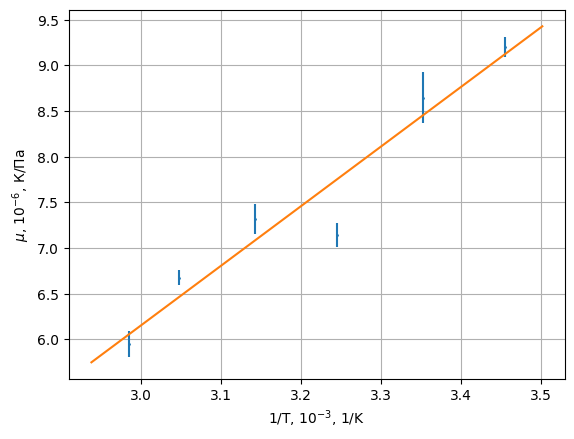

: 

In [166]:
plt.xlabel("1/T, $10^{-3}$, 1/K")
plt.ylabel("$\mu$, $10^{-6}$, К/Па")
k, b_g = linearcalc_error(data_2_output["1/T, $10^{-3}$, 1/K"], data_2_output["$\mu$, $10^{-6}$, К/Па"])
plt.savefig("muT")
k /= 10**3
b_g /= 10**6
Cp = DData(37.1, epsilon=0.15)
R = 8.31
a = k*R*Cp/2
b = - b_g * Cp
a.E = 0
b.E = -6
T_inv = 2*a/b/R
T_krit = 4/27 * T_inv
T_inv.E = 0
T_krit.E = 0
print(f"a = {a}, b = {b}, T_inv = {T_inv}, T_krit = {T_krit}")

In [160]:
data_output.to_clipboard()

In [161]:
data_2_output.to_clipboard()